# SpatiallyVariableGeneDetection_SpatialMultiomicsData

This tutorial demonstrates spatially variable gene detection on spatial multi-omics data using Pysodb and Sepal.

The reference paper can be found at https://academic.oup.com/bioinformatics/article/37/17/2644/6168120 and https://www.cell.com/cell/fulltext/S0092-8674(20)31390-8.

## Import packages and set configurations

In [1]:
# Numpy is a package for numerical computing with arrays
import numpy as np

In [2]:
# Import sepal package and its modules
import sepal.datasets as d
import sepal.models as m
import sepal.utils as ut

## Streamline development of loading spatial data with Pysodb

In [3]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [4]:
# Initialization
sodb = pysodb.SODB()

In [5]:
# Define names of the dataset_name and experiment_name
dataset_name = 'liu2020high'
experiment_name = 'E10_whole_gene_best'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata = sodb.load_experiment(dataset_name,experiment_name)

load experiment[E10_whole_gene_best] in dataset[liu2020high]


In [6]:
# Save the AnnData object to an H5AD file format.
adata.write_h5ad('E10_whole_gene_best.h5ad')

## Perform Sepal to spatially variable gene detection for spatial multi-omics data

In [7]:
# Load in the raw data using a RawData class.
raw_data = d.RawData('E10_whole_gene_best.h5ad')

In [8]:
raw_data

RawData object
	> loaded from E10_whole_gene_best.h5ad
	> using pixel coordinates

In [9]:
# Filter genes observed in less than 5 spots and/or less than 10 total observations
raw_data.cnt = ut.filter_genes(raw_data.cnt,
                               min_expr=10,
                               min_occur=5)

In [10]:
# A subclass of the CountData class that uses the UnstructuredData class to hold data from non-Visium or non-ST arrays.
data = m.UnstructuredData(raw_data,
                          eps = 0.1)


In [11]:
# A propagate class is employ to normalize count data and then propagate it in time, to measure the diffusion time.
# Set scale = True to perform
# Minmax scaling of the diffusion times
times = m.propagate(data,
                    normalize = True,
                    scale =True)

[INFO] : Using 128 workers
[INFO] : Saturated Spots : 819


100%|██████████| 15309/15309 [00:50<00:00, 304.95it/s]


In [12]:
# Selects the top 10 and bottom 20 profiles based on their diffusion times
# Set the number of top and bottom profiles to be selected as 10
n_top = 10
# Computes the indices that would sort the times DataFrame in ascending order
sorted_indices = np.argsort(times.values.flatten())
# Reverses the order of the sorted indices to obtain a descending order
sorted_indices = sorted_indices[::-1]
# Retrieves the profile names corresponding to the sorted indices
sorted_profiles = times.index.values[sorted_indices]
# Select the top 10 profile names with the highest diffusion times
top_profiles = sorted_profiles[0:n_top]
# Selects the bottom 10 profile names with the lowest diffusion times
tail_profiles = sorted_profiles[-n_top:]
# Retrieves the top 10 profiles from the times DataFrame
times.loc[top_profiles,:]

,average
Ttn,1.000000
Myl7,0.870286
Epha3,0.836571
Fabp7,0.719429
Sncg,0.693714
Adgrv1,0.671429
Gap43,0.654857
Myh7,0.649714
Onecut2,0.636000
Sox2,0.629714


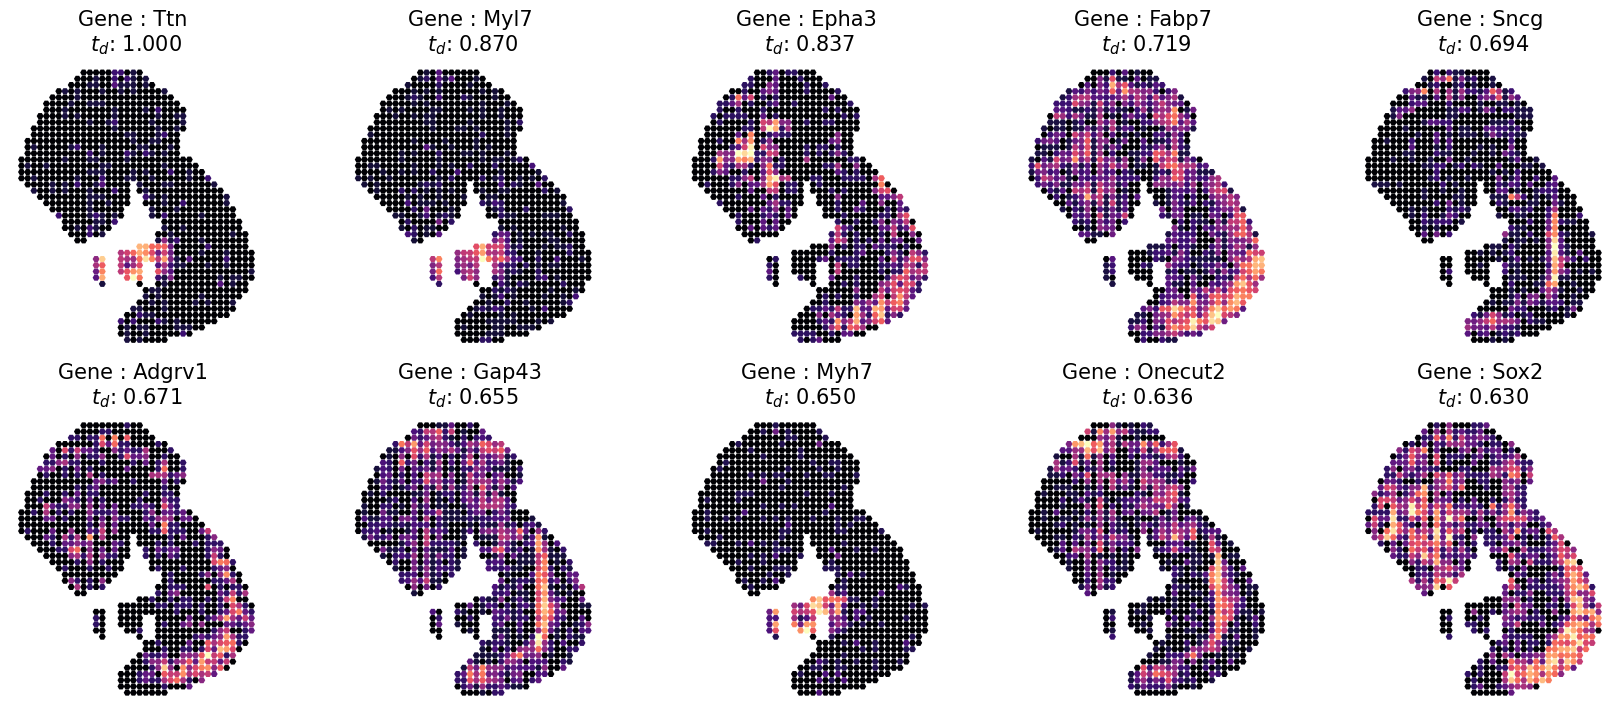

In [13]:
# Inspect detecition visually by using the "plot_profiles function for first 10 SVG
# Define a custom pltargs dictionary with plot style options
pltargs = dict(s = 25,
               cmap = "magma",
               edgecolor = 'none',
               marker = 'H',
               )

# plot the profiles
fig,ax = ut.plot_profiles(cnt = data.cnt.loc[:,top_profiles],
                          crd = data.real_crd,
                          rank_values = times.loc[top_profiles,:].values.flatten(),
                          pltargs = pltargs,
                          )

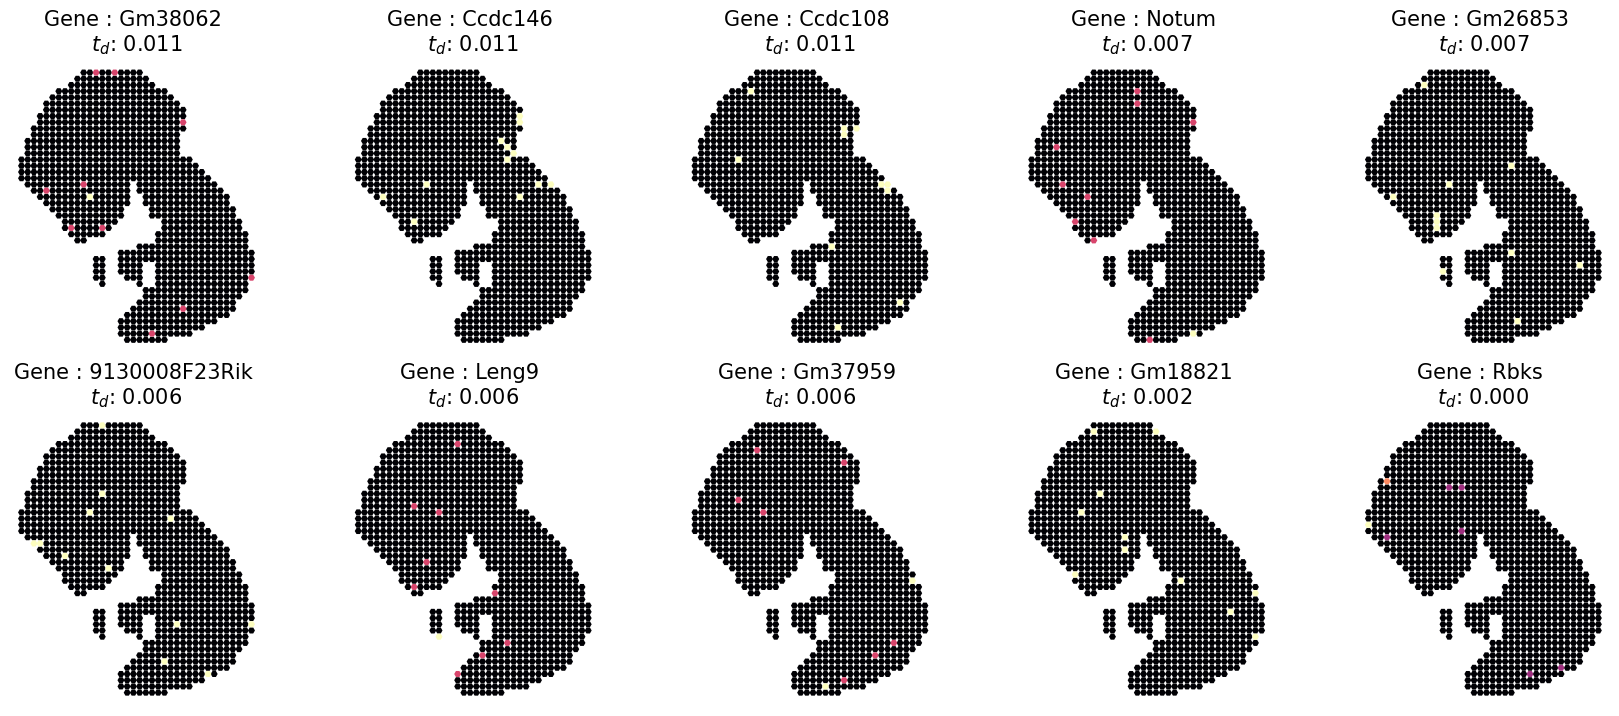

In [14]:
# Inspect detecition visually by using the "plot_profiles function for last 10 SVG
# Define a custom pltargs dictionary with plot style options
pltargs = dict(s = 25,
               cmap = "magma",
               edgecolor = 'none',
               marker = 'H',
               )

# plot the profiles
fig,ax = ut.plot_profiles(cnt = data.cnt.loc[:,tail_profiles],
                          crd = data.real_crd,
                          rank_values = times.loc[tail_profiles,:].values.flatten(),
                          pltargs = pltargs,
                          )